# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

The most important asset in any company is is the people—the human capita. It’s important to  find great talent, and more importantly to keep the great talent happy and loyal to the company.

Salary, without a doubt is a great factor in attracting great people and keep people happy in the organization.

In this project, we want to find out:

1. With the data available, can we develop a model that predicts the salary for a specific job and profile? 

2. How accurate can we get? 

In [1]:
# Import your libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import RFECV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
pd.options.display.max_columns = 999
pd.options.display.float_format = '{:,.2f}'.format


# My info here
__author__ = "Sha Brown"
__email__ = "sha821@gmail.com"

In [2]:
# A list of functions that we will be using later on
def read_data(file):
    
    """ Read data into pandas dataframe
    
    Args:
    
    file(str): file name
    
    Return:
    
    df(datafame)
    
    """
    
    df = pd.read_csv(file)
    return df

def find_boundaries(df, col):
    
    """ Identify outliers by using IQR rule
    
    Args:
    
    df(dataframe): pandas dataframe
    col(str): column name
    
    Return:
    lower_boundary: lower boundary of the outliers as a float number
    upper_boundary: upper boundary of the outliers as a float number
    
    """

    IQR = df[col].quantile(0.75) - df[col].quantile(0.25)

    lower_boundary = df[col].quantile(0.25) - (IQR * 1.5)
    upper_boundary = df[col].quantile(0.75) + (IQR * 1.5)

    return upper_boundary, lower_boundary

def plot_feature(df, col):
    
    ''' Make plot for each features
    Left plot is the distribution on the feature
    Righ plot the dependance of salary on the feature
    
    Args:
    
    df(dataframe): pandas dataframe
    col(str): column name
    
    '''
    
    plt.figure(figsize = (14, 6))
    sns.set(style = 'dark', context = 'notebook')
    plt.subplot(1, 2, 1)
    
    if df[col].dtype == 'int64':
        df[col].value_counts().sort_index().plot()
      
        
    else:
        #change the categorical variable to category type and order their level by the mean salary
        #in each category
        df[col].value_counts().sort_values(ascending = False)\
               .plot.bar(color = 'skyblue', alpha = 0.8)
        
    plt.xticks(rotation=45)
    plt.xlabel('{}'.format(col))
    plt.ylabel('Count')
    
    plt.subplot(1, 2, 2)
    
    if df[col].dtype == 'int64':
        #plot the mean salary for each category and fill between the (mean - std, mean + std)
        mean = df.groupby(col)['salary'].mean()
        std = df.groupby(col)['salary'].std()
        mean.plot()
        plt.fill_between(range(len(std.index)), mean.values-std.values, mean.values + std.values, \
                         alpha = 0.1)

    else:
        label_order = (salary_df.groupby(col)['salary']
                           .mean()
                           .sort_values()
                           .index)
    
                
        sns.boxplot(x = col, 
                    y = 'salary', 
                    data=df, 
                    order=label_order)
            
    plt.xticks(rotation=45)
    plt.ylabel('Salaries')
    plt.show()

def standard_scaler(df):
    """ Transform numerical vairables with Standard Scaler
    
    Args:
    
    df(dataframe): dataframe   
    
    Return:
    
    df(dataframe)
    """
    numerical_cols = features.select_dtypes(include=['float64', 'int64']).columns
    for col in numerical_cols:
        scaler = StandardScaler()
        df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    return df

def create_dummies(df, col):
    """ One hot encoding for categorical variables
    
    Args:
    
    df(dataframe): dataframe
    col(str): column name
   
    Return:
    
    df(dataframe)
    """
    categorical_cols = ['job_type', 'degree', 'major', 'industry']
    for col in categorical_cols:
        dummies = pd.get_dummies(df[col], prefix = col)
        df = pd.concat([df, dummies], axis = 1)
    return df    

def select_features(instantiating_model):
    model = instantiating_model
    model.fit(features_train, target_train)
    important_features = pd.DataFrame(model.feature_importances_, features_train.columns)
    important_features.columns = ['importance']
    important_features = important_features.sort_values(by = 'importance', ascending = False).head(15)
    print('Most important features are {}'.format(important_features.index))
    return important_features

## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [3]:
# Load the data into a Pandas dataframe
salary_df = read_data('salary_main .csv')

In [4]:
# Display the shape of the dataframe
salary_df.shape

(1000000, 9)

In [5]:
# Display the first 5 rows
salary_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,102
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [6]:
# Rename the column names
salary_df.rename(columns={'jobId': 'job_id',
                          'companyId': 'company_id',
                          'jobType': 'job_type',
                          'yearsExperience': 'years_experience',
                          'milesFromMetropolis': 'miles_from_metropolis'},
                 inplace=True
                )

In [7]:
# Verify that the column names have been replaced
salary_df.head(1)

,job_id,company_id,job_type,degree,major,industry,years_experience,miles_from_metropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130


In [8]:
# Show the infomation of the dataframe
salary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column                 Non-Null Count    Dtype 
---  ------                 --------------    ----- 
 0   job_id                 1000000 non-null  object
 1   company_id             1000000 non-null  object
 2   job_type               1000000 non-null  object
 3   degree                 1000000 non-null  object
 4   major                  1000000 non-null  object
 5   industry               1000000 non-null  object
 6   years_experience       1000000 non-null  int64 
 7   miles_from_metropolis  1000000 non-null  int64 
 8   salary                 1000000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 68.7+ MB


In [9]:
# Summary statistics on categorical features
salary_df.describe(include=['object'])

,job_id,company_id,job_type,degree,major,industry
count,1000000,1000000,1000000,1000000,1000000,1000000
unique,1000000,63,8,5,9,7
top,JOB1362684803273,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB
freq,1,16193,125886,236976,532355,143206


In [10]:
# Summary statitiscs on numerical features
salary_df.describe(include=['int'])

,years_experience,miles_from_metropolis,salary
count,"1,000,000.00","1,000,000.00","1,000,000.00"
mean,11.99,49.53,116.06
std,7.21,28.88,38.72
min,0.00,0.00,0.00
25%,6.00,25.00,88.00
50%,12.00,50.00,114.00
75%,18.00,75.00,141.00
max,24.00,99.00,301.00


### ---- 3 Clean the data ----

In [11]:
# Look for duplicate data in the training set
salary_df.duplicated().sum()

0

In [12]:
# Look for invalid or missing data in the training set
salary_df.isnull().sum()

job_id                   0
company_id               0
job_type                 0
degree                   0
major                    0
industry                 0
years_experience         0
miles_from_metropolis    0
salary                   0
dtype: int64

#### Use IQR rule to identify potential outliers


In [13]:
# Find upper and lower boundaries
upper_boundary, lower_boundary = find_boundaries(salary_df, 'salary')
print('The upper boundary is: {}'.format(upper_boundary))
print('The lower boundary is: {}'.format(lower_boundary))

The upper boundary is: 220.5
The lower boundary is: 8.5


In [14]:
# Find outliers in salary_df
outliers = np.where(salary_df['salary'] > upper_boundary, True,
                    np.where(salary_df['salary'] < lower_boundary, True, False))

In [15]:
# Total outliers in the dataset
outliers.sum()

7122

In [16]:
# Display outliers below lower boundary
salary_df.loc[salary_df['salary']<8.5]

,job_id,company_id,job_type,degree,major,industry,years_experience,miles_from_metropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


In [17]:
# Display outliers above the upper boundary
salary_df.loc[salary_df['salary']>220.5].head()

,job_id,company_id,job_type,degree,major,industry,years_experience,miles_from_metropolis,salary
266,JOB1362684407953,COMP30,CEO,MASTERS,BIOLOGY,OIL,23,60,223
362,JOB1362684408049,COMP38,CTO,MASTERS,NONE,HEALTH,24,3,223
560,JOB1362684408247,COMP53,CEO,MASTERS,BIOLOGY,WEB,22,7,248
670,JOB1362684408357,COMP26,CEO,MASTERS,MATH,AUTO,23,9,240
719,JOB1362684408406,COMP54,VICE_PRESIDENT,DOCTORAL,BIOLOGY,OIL,21,14,225


In [18]:
# Check outliers counts in job_type
salary_df.loc[salary_df['salary']>220.5, 'job_type'].value_counts()

CEO               3227
CFO               1496
CTO               1488
VICE_PRESIDENT     603
MANAGER            217
SENIOR              66
JUNIOR              20
Name: job_type, dtype: int64

In [19]:
# Display outliers of juniors as job_type
salary_df[(salary_df['salary'] > 222.5) & (salary_df['job_type'] == 'JUNIOR')]

,job_id,company_id,job_type,degree,major,industry,years_experience,miles_from_metropolis,salary
1222,JOB1362684408909,COMP40,JUNIOR,MASTERS,COMPSCI,OIL,24,5,225
27710,JOB1362684435397,COMP21,JUNIOR,DOCTORAL,ENGINEERING,OIL,24,3,246
31355,JOB1362684439042,COMP45,JUNIOR,DOCTORAL,COMPSCI,FINANCE,24,0,225
100042,JOB1362684507729,COMP17,JUNIOR,DOCTORAL,BUSINESS,FINANCE,23,8,248
160333,JOB1362684568020,COMP18,JUNIOR,DOCTORAL,BUSINESS,FINANCE,22,3,223
303778,JOB1362684711465,COMP51,JUNIOR,MASTERS,ENGINEERING,WEB,24,2,226
348354,JOB1362684756041,COMP56,JUNIOR,DOCTORAL,ENGINEERING,OIL,23,25,226
500739,JOB1362684908426,COMP40,JUNIOR,DOCTORAL,ENGINEERING,OIL,21,0,227
627534,JOB1362685035221,COMP5,JUNIOR,DOCTORAL,ENGINEERING,OIL,24,29,230
645555,JOB1362685053242,COMP36,JUNIOR,DOCTORAL,BUSINESS,FINANCE,24,1,225


In [20]:
# Remove data with zero salaries
salary_df = salary_df.loc[salary_df['salary']>8.5]

### ---- 4 Explore the data (EDA) ----

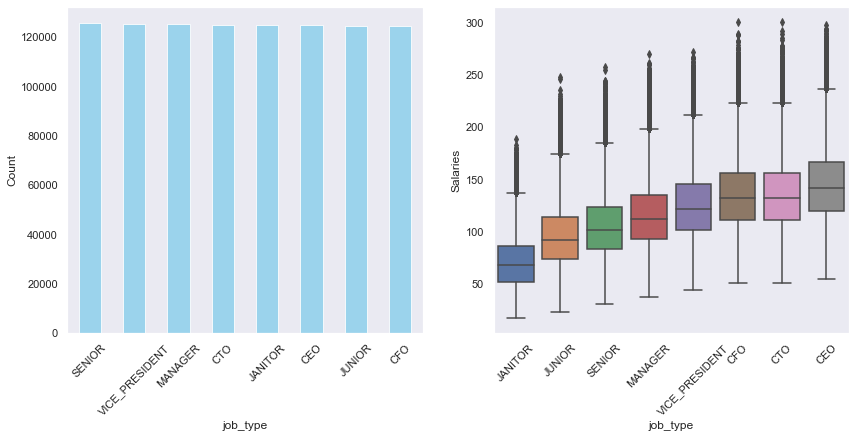

In [21]:
plot_feature(salary_df, 'job_type')

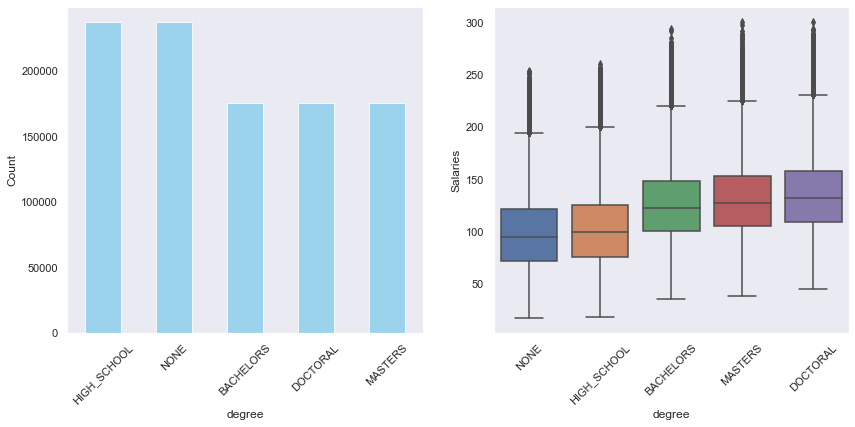

In [22]:
#### Create histogram for years of experiences and miles from metropolis
plot_feature(salary_df, 'degree')

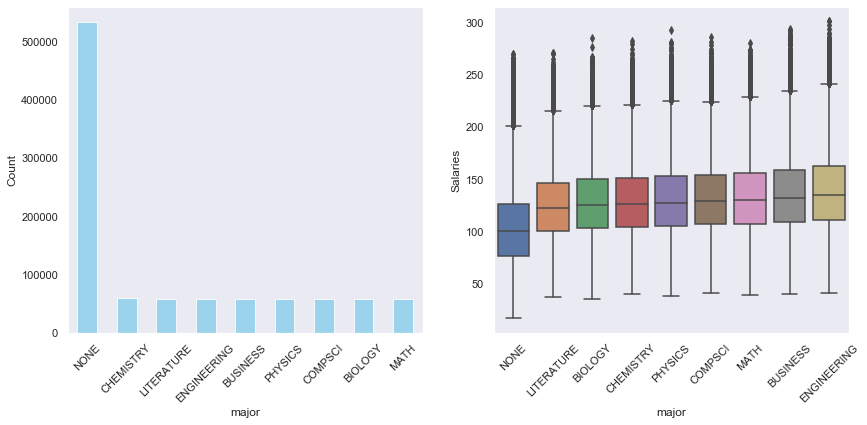

In [23]:
#### Create boxplots for years of experiences, miles from metropolis and salary
plot_feature(salary_df, 'major')

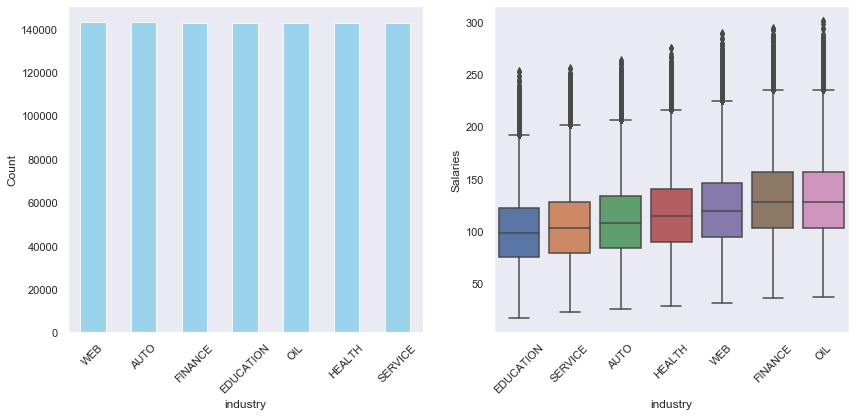

In [24]:
plot_feature(salary_df, 'industry')

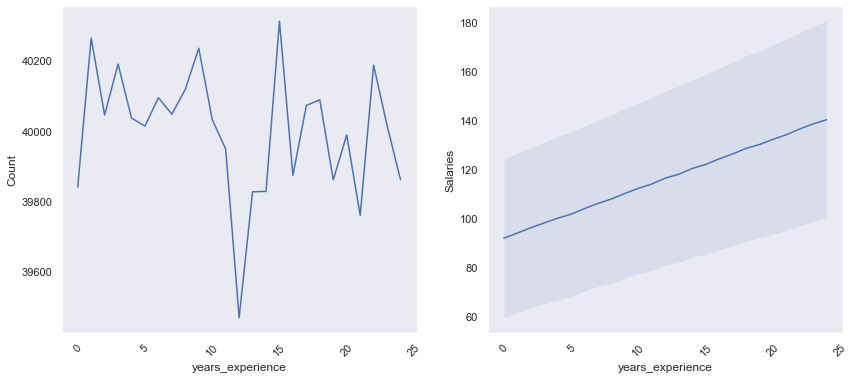

In [25]:
plot_feature(salary_df, 'years_experience')

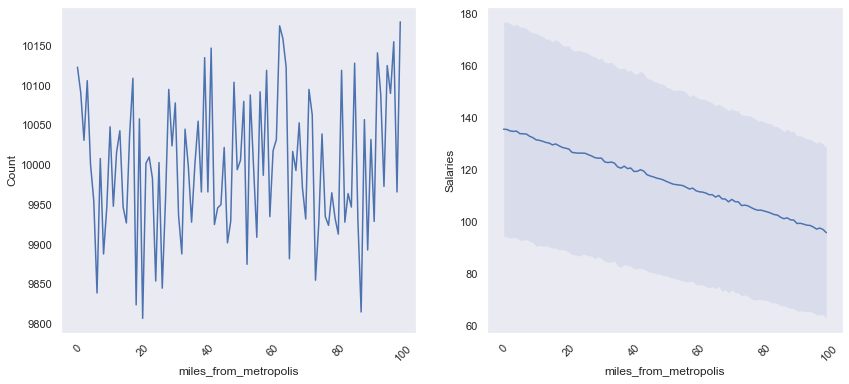

In [26]:
plot_feature(salary_df, 'miles_from_metropolis')

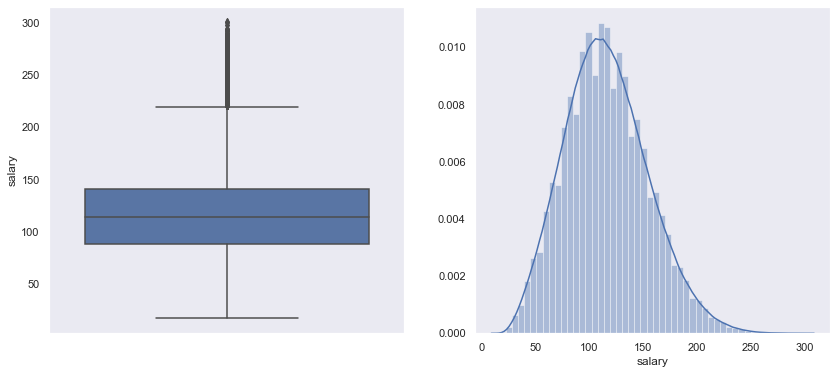

In [27]:
# plot the target variable
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
sns.boxplot(salary_df['salary'], orient='v')
plt.subplot(1,2,2)
sns.distplot(salary_df['salary'])

### Explore correlations between each feature and the target

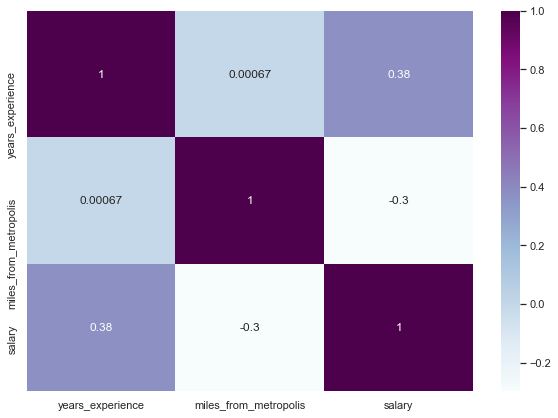

In [28]:
# Create a matrix to show correlations
matrix = salary_df.corr()
plt.figure(figsize=(10,7))
sns.heatmap(matrix, cmap='BuPu', annot=True)

### ---- 5 Establish a baseline ----

Since this is a project to predict numeric values. We will establish a baseline with a simple linear regression model.

In [29]:
baseline_features = salary_df.drop(columns=['job_id', 'company_id', 'salary']).copy()
target = salary_df['salary'].copy()

In [31]:
# Encode categorical variables with integers
enc = OrdinalEncoder()
for col in baseline_features.select_dtypes(include='object').columns:
    baseline_features[col] = enc.fit_transform(baseline_features[[col]])

In [32]:
# Create training and testing sets
feat_train, feat_test, target_train, target_test = train_test_split(baseline_features, target, 
                                                                    test_size=0.3, 
                                                                    shuffle=True,
                                                                    random_state=42
                                                                    )

In [33]:
# Establish a baseline model with Linear Regression

lr = LinearRegression()

lr.fit(feat_train, target_train)

predictions = lr.predict(feat_test)

mse = mean_squared_error(target_test, predictions)

rmse = np.sqrt(mse)

print('MSE for the baseline model is {:0.2f}'.format(mse))
print('RMSE for the baseline model is {:0.2f}'.format(rmse))

MSE for the baseline model is 925.31
RMSE for the baseline model is 30.42


### ---- 6 Hypothesize solution ----

The baseline model does a decent job of predicting salary. There are still a lot of room to improve the performance:

The larger the variance in the variables, the strong impact it does for the model. So we can scale all the numerical variables in the dataset.

We will test the model by using Random Tree model.

Gradient Boosting Regressor is very robust as well.

It also makes sense that people who have similar background may have similar salary. So we will also test KNearest Neighbor.

## Part 3 - DEVELOP

We will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

#### Your metric will be MSE and your goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

### ---- 7 Feature Engineering ----

In [34]:
def label_encoder(df, col):
    
    ordered_labels = salary_df.groupby([col])['salary'].mean().to_dict()

    return ordered_labels

In [35]:
for col in salary_df.columns:
    if salary_df[col].dtype == 'object':
        labels = label_encoder(salary_df, col)
        salary_df[col] = salary_df[col].map(labels)

In [36]:
salary_df.head()

,job_id,company_id,job_type,degree,major,industry,years_experience,miles_from_metropolis,salary
0,130,115.35,135.46,130.51,133.32,115.74,10,83,130
1,102,115.76,145.31,101.92,102.58,121.65,3,73,102
2,137,116.22,125.37,135.49,130.37,115.74,10,38,137
3,142,116.20,115.37,135.49,129.07,109.44,8,17,142
4,163,115.89,125.37,125.45,130.37,130.75,8,16,163


In [37]:
# Create a correlation heatmap
matrix = salary_df.corr()
matrix['salary'].sort_values(ascending=False)

salary                   1.00
job_id                   1.00
job_type                 0.60
degree                   0.40
major                    0.38
years_experience         0.38
industry                 0.30
company_id               0.01
miles_from_metropolis   -0.30
Name: salary, dtype: float64

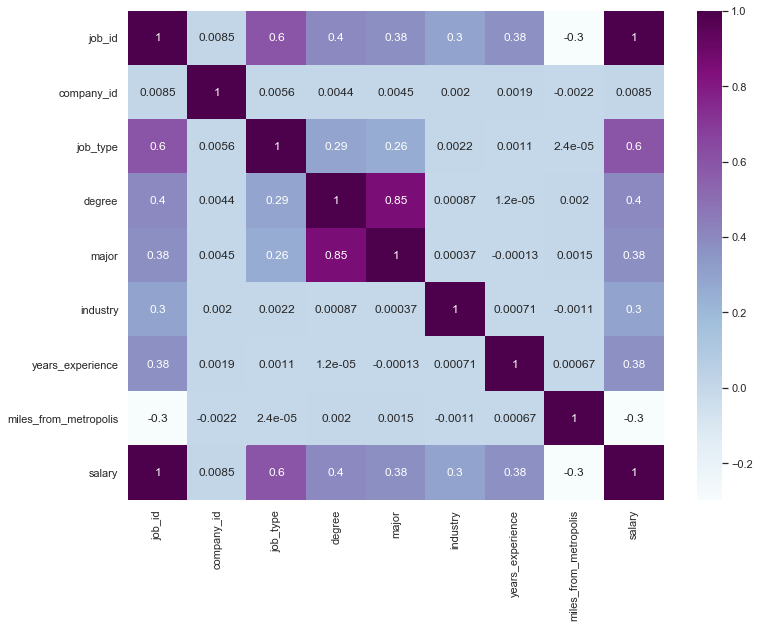

In [38]:
plt.figure(figsize=(12,9))
sns.heatmap(matrix, cmap='BuPu', annot=True)

### ---- 8 Create models ----

In [44]:
features = salary_df.drop(columns=['job_id', 'company_id', 'salary']).copy()
target = salary_df['salary'].copy()

In [45]:
def train_model(model, feature_df, target_df, num_procs, mean_mse, cv_std):
    neg_mse = cross_val_score(model, feature_df, target_df, cv=2, n_jobs=num_procs, scoring='neg_mean_squared_error')
    mean_mse[model] = -1.0*np.mean(neg_mse)
    cv_std[model] = np.std(neg_mse)

def print_summary(model, mean_mse, cv_std):
    print('\nModel:\n', model)
    print('Average MSE:\n', mean_mse[model])
    print('Standard deviation during CV:\n', cv_std[model])

In [49]:
def select_model(feat_train, target_train):

    # List of dictionaries, each containing a model name,
    # it's estimator and a dict of hyperparameters
    models = [
        {
            "name": "RandomForestRegressor",
            "estimator": RandomForestRegressor(random_state=42),
            "hyperparameters":
                {
                    "n_estimators": [150],
                    "max_depth": [25],
                    "min_samples_split": [60],
                    "verbose": [0]

                }
        },
        {
            "name": "GradientBoostingRegressor",
            "estimator": GradientBoostingRegressor(random_state=42),
             "hyperparameters":
                {
                    "n_estimators": [150],
                    "max_depth": [5],
                    "loss": ['ls'],
                    "verbose": [0]

                }
        }
        ]

    for model in models:
        print(model['name'])
        print('-'*len(model['name']))
  
        
        neg_mse = cross_val_score(model['estimator'], feat_train, target_train, 
                                  cv=2, n_jobs=2, 
                                  scoring='neg_mean_squared_error')
        
        mean_mse = -1.0*np.mean(neg_mse)
        cv_std = np.std(neg_mse)
        print('\nModel:\n', model['name'])
        print('Average MSE:\n', mean_mse)
        print('Standard deviation during CV:\n', cv_std)
        
    return models

In [50]:
# Create training and testing set
feat_train, feat_test, target_train, target_test = train_test_split(features, target, 
                                                                    test_size=0.3, 
                                                                    shuffle=True,
                                                                    random_state=42
                                                                    )

In [51]:
select_model(feat_train, target_train)

RandomForestRegressor
---------------------

Model:
 RandomForestRegressor
Average MSE:
 432.9723656896092
Standard deviation during CV:
 0.113874495581058
GradientBoostingRegressor
-------------------------

Model:
 GradientBoostingRegressor
Average MSE:
 366.63188048638995
Standard deviation during CV:
 1.066356628750583


[{'name': 'RandomForestRegressor',
  'estimator': RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                        max_depth=None, max_features='auto', max_leaf_nodes=None,
                        max_samples=None, min_impurity_decrease=0.0,
                        min_impurity_split=None, min_samples_leaf=1,
                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                        n_estimators=100, n_jobs=None, oob_score=False,
                        random_state=42, verbose=0, warm_start=False),
  'hyperparameters': {'n_estimators': [150],
   'max_depth': [25],
   'min_samples_split': [60],
   'verbose': [0]}},
 {'name': 'GradientBoostingRegressor',
  'estimator': GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                            init=None, learning_rate=0.1, loss='ls', max_depth=3,
                            max_features=None, max_leaf_nodes=None,
                            min_impurity_d

### ---- 9 Test models ----

In [52]:
best_model = GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                            init=None, learning_rate=0.1, loss='ls', max_depth=3,
                            max_features=None, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_impurity_split=None,
                            min_samples_leaf=1, min_samples_split=2,
                            min_weight_fraction_leaf=0.0, n_estimators=100,
                            n_iter_no_change=None, presort='deprecated',
                            random_state=42, subsample=1.0, tol=0.0001,
                            validation_fraction=0.1, verbose=0, warm_start=False)

In [53]:
best_model.fit(feat_train, target_train)
predictions = best_model.predict(feat_test)

mse = mean_squared_error(target_test, predictions)
rmse = np.sqrt(mse)

print('MSE for the model is {:0.2f}'.format(mse))
print('RMSE for the model is {:0.2f}'.format(rmse))

MSE for the model is 366.24
RMSE for the model is 19.14
